In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range
import notMNIST_gen

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
save = notMNIST_gen.gen_composite()
train_dataset = save['train_dataset']
train_labels = save['train_labels']
valid_dataset = save['valid_dataset']
valid_labels = save['valid_labels']
test_dataset = save['test_dataset']
test_labels = save['test_labels']
del save  # hint to help gc free up memory
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Starting
Download Complete
Extract Complete
Saving Complete
Data Dictionaries Built
Training set (200000, 64, 64) (200000,)
Validation set (10000, 64, 64) (10000,)
Test set (10000, 64, 64) (10000,)


In [3]:
labels = train_labels
new_labels = labels.view('S1').reshape((labels.size, -1))
print(new_labels[0])

[b'A' b'B' b'E' b'H' b' ']


In [4]:
image_size = 64
num_digits = 5
char_labels = [b'A',b'B',b'C',b'D',b'E',b'F',b'G',b'H',b'I',b'J',b' ']
num_labels = len(char_labels)
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size)).astype(np.uint8)
  dataset_edges = np.zeros(dataset.shape, dtype=np.float32)
  for i in range(dataset.shape[0]):
    line_image = np.copy(dataset[i,:,:])
    dst = cv2.blur(line_image, (5, 5))
#    dst = line_image
    edges = cv2.Canny(dst, 100, 200)
    dataset_edges[i,:,:] = edges.astype(np.float32)
#    dataset_edges[i,:,:] = line_image.astype(np.float32)
#    plt.imshow(edges), plt.xticks([]), plt.yticks([])
#    print(mnist['train_labels'][0], mnist['train_dataset'][0].shape)
  labels = labels.view('S1').reshape((labels.size, -1))
  new_labels = np.ndarray(labels.shape, dtype=np.float32)
  for i in range(new_labels.shape[0]):
    for j in range(new_labels.shape[1]):
        if labels[i,j] in char_labels:
            new_labels[i,j] = char_labels.index(labels[i,j])
  labels = (np.arange(num_labels) == new_labels[:,:,None])
  labels = labels.astype(np.float32)
  dataset = dataset_edges.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 64, 64, 1) (200000, 5, 11)
Validation set (10000, 64, 64, 1) (10000, 5, 11)
Test set (10000, 64, 64, 1) (10000, 5, 11)


[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]] (5, 11)


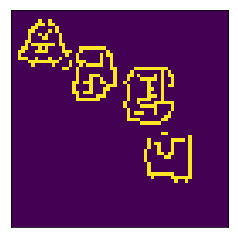

In [5]:
plt.imshow(train_dataset[0,:,:,0]), plt.xticks([]), plt.yticks([])
print(train_labels[0], train_labels[0].shape)

In [6]:
print(train_labels[0])

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [7]:
def accuracy(predictions, labels):
#    print(predictions.shape, labels.shape)
    correct_digits = (np.argmax(predictions, 2) == np.argmax(labels, 2))
#    print(correct_digits.shape)
    correct_addrs = np.all(correct_digits, 1)
#    print(np.argmax(predictions, 2)[0], np.argmax(labels, 2)[0])
#    print(correct_digits[0, :], correct_addrs[0])
    return (100.0 * np.sum(correct_addrs) / predictions.shape[0])

In [28]:
batch_size = 12
patch_size = 5
depth = 16
num_hidden = 32

graph = tf.Graph()

with graph.as_default():
  with tf.name_scope('input_variables'):
      tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels), 
          name='train_dataset_in')
      tf_train_labels = tf.placeholder(
          tf.float32, shape=(batch_size, num_digits, num_labels), name='train_labels_in')
      tf_valid_dataset = tf.constant(valid_dataset, name='valid_dataset_in')
      tf_test_dataset = tf.constant(test_dataset, name='valid_labels_in')
      tf_keep_prob = tf.constant(0.5, name='keep_probability')

  def cnn_var_dict():
      var_dict = {}
      with tf.name_scope('convolutional_net_variables'):
          var_dict['layer_1_weights'] = tf.Variable(tf.truncated_normal(
              [patch_size, patch_size, num_channels, depth], stddev=0.1), 
                                                   name='cnn_layer_1_weights')
          var_dict['layer_1_biases'] = tf.Variable(tf.zeros([depth]), 
                                                  name='cnn_layer_1__biases')
          var_dict['layer_2_weights'] = tf.Variable(tf.truncated_normal(
              [patch_size, patch_size, depth, depth*4], stddev=0.1), 
                                                   name='cnn_layer_2_weights')
          var_dict['layer_2_biases'] = tf.Variable(tf.constant(1.0, shape=[depth*4]), 
                                                  name='cnn_layer_2_biases')
          for key in var_dict:
            tf.summary.histogram(key + '_summary', var_dict[key])
      return var_dict

  def variable_dict(digit):
      var_dict = {}
      with tf.name_scope('Digit_' + digit + '_variables'):
          var_dict['layer_1_weights'] = tf.Variable(tf.truncated_normal(
              [image_size // 2 * image_size // 2 * depth, num_hidden*3], stddev=0.1), 
                                                   name='layer_1_'+ digit + '_weights')
          var_dict['layer_1_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden*3]), 
                                                  name='layer_1_'+ digit + '_biases')
          var_dict['layer_2_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden*3, num_hidden*2], stddev=0.1), 
                                                   name='layer_2_'+ digit + '_weights')
          var_dict['layer_2_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden*2]), 
                                                  name='layer_2_'+ digit + '_biases')
          var_dict['layer_3_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden*2, num_hidden*2], stddev=0.1), 
                                                   name='layer_3_'+ digit + '_weights')
          var_dict['layer_3_biases'] = tf.Variable(tf.constant(1.0, shape=[num_hidden*2]), 
                                                  name='layer_3_'+ digit + '_biases')
          var_dict['layer_4_weights'] = tf.Variable(tf.truncated_normal(
              [num_hidden*2, num_labels], stddev=0.1), name='layer_4_'+ digit + '_weights')
          var_dict['layer_4_biases'] = tf.Variable(tf.constant(1.0, shape=[num_labels]), 
                                                  name='layer_4_'+ digit + '_biases')
          for key in var_dict:
            tf.summary.histogram(key + '_summary', var_dict[key])
      return var_dict

  cnn_vars = cnn_var_dict()
  deep_vars = {}
  for i in range(num_digits):
        deep_vars[str(i)] = variable_dict(str(i))
                      
  # Model.
  def cnn_model(data, var_set):
    with tf.name_scope('convolutional_net_operations'):
        conv_1 = tf.nn.conv2d(data, var_set['layer_1_weights'], [1, 2, 2, 1], padding='SAME', 
                            name='Convolution_1')
        conv_1 = tf.nn.max_pool(conv_1, [1, 4, 4, 1], [1, 1, 1, 1], padding='SAME', name='Max_Pool_1')
        conv_1 = tf.nn.relu(conv_1 + var_set['layer_1_biases'], name='CNN_Relu_1')
        conv_2 = tf.nn.conv2d(conv_1, var_set['layer_2_weights'], [1, 2, 2, 1], padding='SAME', 
                            name='Convolution_2')
        conv_2 = tf.nn.max_pool(conv_2, [1, 4, 4, 1], [1, 1, 1, 1], padding='SAME', name='Max_Pool_2')
        conv_2 = tf.nn.relu(conv_2 + var_set['layer_2_biases'], name='CNN_Relu_2')
        shape = conv_2.get_shape().as_list()
        reshape = tf.reshape(conv_2, [shape[0], shape[1] * shape[2] * shape[3]], name='Collapse_to_2d')
    return reshape

  def digit_model(data, digit, keep_prob=1):
      with tf.name_scope('Digit_' + digit + '_operations'):
        hidden_1 = tf.nn.relu(tf.matmul(data, deep_vars['0']['layer_1_weights']) + 
                              deep_vars[digit]['layer_1_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_1')
        drop_1 = tf.nn.dropout(hidden_1, keep_prob)
        hidden_2 = tf.nn.relu(tf.matmul(drop_1, deep_vars['0']['layer_2_weights']) + 
                              deep_vars[digit]['layer_2_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_2')
        drop_2 = tf.nn.dropout(hidden_2, keep_prob)
        hidden_3 = tf.nn.relu(tf.matmul(drop_2, deep_vars['0']['layer_3_weights']) + 
                              deep_vars[digit]['layer_3_biases'], 
                              name='Digit_' + digit + '_Deep_Relu_3')
        drop_3 = tf.nn.dropout(hidden_3, keep_prob)
        result = tf.matmul(drop_3, deep_vars['0']['layer_4_weights']) + \
                            deep_vars[digit]['layer_4_biases']
      return result

  def base_model(data, keep_prob=1):
      with tf.name_scope('base_model'):
          cnn = cnn_model(data, cnn_vars)
          logit_stack = list()
          for i in range(num_digits):
              logit_stack.append(digit_model(cnn, str(i), keep_prob))
      return tf.stack(logit_stack, axis=1)

  def train_model(logits, labels):
      with tf.name_scope('train_model'):
        softmax_stack = list()
        pred = list()
        for i in range(num_digits):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits[:,i,:], labels[:,i,:])
            softmax_stack.append(tf.reduce_mean(cross_entropy))
        loss = tf.reduce_mean(tf.stack(softmax_stack), name='loss_function')
      return loss

  def make_prediction(logits):
      with tf.name_scope('test_model'):
        pred = list()
        for i in range(num_digits):
              pred.append(tf.nn.softmax(logits[:,i,:]))
        return tf.stack(pred, axis=1)

  # Training computation.
  with tf.name_scope('training_computation'):
      logits = base_model(tf_train_dataset, tf_keep_prob)
      loss = train_model(logits, tf_train_labels)

  with tf.name_scope('optimizer_computation'):
      global_step = tf.Variable(0, name='global_step')  # count the number of steps taken.
      learning_rate = tf.train.exponential_decay(0.01, global_step, 50, 0.98, name='learning_rate')
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step, 
                                                                 name='optimizer')
  
  # Predictions for the validation, and test data.
  with tf.name_scope('predictions'):
      train_prediction = make_prediction(logits)
      valid_prediction = make_prediction(base_model(tf_valid_dataset))
      test_prediction = make_prediction(base_model(tf_test_dataset))

In [ ]:
num_steps = 10001

training_track = {}

with tf.Session(graph=graph) as session:
  writer = tf.summary.FileWriter('logs/nn_logs', graph=graph)
  merged = tf.summary.merge_all()
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :, :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, summary, l, predictions, learn = session.run(
      [optimizer, merged, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    writer.add_summary(summary, step)
    if (step % 1000 == 0):
      print('Step %5d batch loss: %8.4f \t Learing Rate: %0.5f' % (step, l, learn), end='\t\t')
      train_accuracy = accuracy(predictions, batch_labels)
      print('Batch accuracy: %.1f%%' % train_accuracy, end='\t')
      valid_pred = valid_prediction.eval()
      valid_accuracy = accuracy(valid_pred, valid_labels)
      print('Validation accuracy: %.1f%%' % valid_accuracy)
      training_track[step] = (train_accuracy, valid_accuracy)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Step     0 batch loss: 1140.2043 	 Learing Rate: 0.01000		Batch accuracy: 0.0%	Validation accuracy: 0.0%
Step  1000 batch loss:   1.0663 	 Learing Rate: 0.00668		Batch accuracy: 0.0%	Validation accuracy: 6.2%
Step  2000 batch loss:   1.0269 	 Learing Rate: 0.00446		Batch accuracy: 0.0%	Validation accuracy: 4.4%
Step  3000 batch loss:   1.0434 	 Learing Rate: 0.00298		Batch accuracy: 8.3%	Validation accuracy: 7.0%
Step  4000 batch loss:   0.8416 	 Learing Rate: 0.00199		Batch accuracy: 16.7%	Validation accuracy: 8.7%


### After increasing convolution depth

Decay: 0.01, Grade: 50, Rate: 0.98
Validation accuracy with edge detection: %

### Before increasing convolution depth

Decay: 0.01, Grade: 25, Rate: 0.98  
    Validation accuracy with edge detection: 9.6%  
    Validation accuracy with base image:    %  

Decay: 0.01, Grade: 50, Rate: 0.98  
    Validation accuracy with edge detection: 15.2%  
    Validation accuracy with base image:    %  
    
Decay: 0.01, Grade: 100, Rate: 0.98  
    Validation accuracy with edge detection: 14.7%  
    Validation accuracy with base image:    11.7%  

Decay: 0.01, Grade: 250, Rate: 0.98  
    Validation accuracy with edge detection: 14.1%  
    Validation accuracy with base image:     11.5%  

Decay: 0.01, Grade: 500, Rate: 0.98  
    Validation accuracy with edge detection: 12.7%  
    Validation accuracy with base image:    %  
